Udacity Data Scientist Nanodegree Project 1: Working through the CRISP-DM process
===============

# Introduction
The CRISP-DM or cross-industry standard process for data mining process is an open process model that allows us to carry out data mining using defined and systematic steps. This method was proven to be efficient while using data to provide insight and offer solutions for businesses.

This process comprises of six major phases that we will work through here:
- Business Understanding
- Data Understanding
- Data Preparation
- Modeling
- Evaluation
- Deployment

In the case of the Udacity Project here, we had to select a dataset before starting the CRISP-DM process. I decided to work with the Stackoverflow surveys data from 2019 to 2022.

## Business Understanding
This include questions that a business is asking and needs solutions for. 
My three main business questions are:

{pick a demographic - data science people}
- What type of cloud platform do data scientist want to learn to use?
- What coding languages are in demand in the data science world. 
- 

In [2]:
## Data Understanding
### Looking at the data


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
%matplotlib inline

df2022 = pd.read_csv('./survey_results_public2022.csv')

In [4]:
df2022.shape

(73268, 79)

In 2022, more than 73000 people answered the survey in Stackoverflow

In [41]:
#Let's take a look at the column headers
df2022.columns

Index(['ResponseId', 'MainBranch', 'Employment', 'RemoteWork',
       'CodingActivities', 'EdLevel', 'LearnCode', 'LearnCodeOnline',
       'LearnCodeCoursesCert', 'YearsCode', 'YearsCodePro', 'DevType',
       'OrgSize', 'PurchaseInfluence', 'BuyNewTool', 'Country', 'Currency',
       'CompTotal', 'CompFreq', 'LanguageHaveWorkedWith',
       'LanguageWantToWorkWith', 'DatabaseHaveWorkedWith',
       'DatabaseWantToWorkWith', 'PlatformHaveWorkedWith',
       'PlatformWantToWorkWith', 'WebframeHaveWorkedWith',
       'WebframeWantToWorkWith', 'MiscTechHaveWorkedWith',
       'MiscTechWantToWorkWith', 'ToolsTechHaveWorkedWith',
       'ToolsTechWantToWorkWith', 'NEWCollabToolsHaveWorkedWith',
       'NEWCollabToolsWantToWorkWith', 'OpSysProfessional use',
       'OpSysPersonal use', 'VersionControlSystem', 'VCInteraction',
       'VCHostingPersonal use', 'VCHostingProfessional use',
       'OfficeStackAsyncHaveWorkedWith', 'OfficeStackAsyncWantToWorkWith',
       'OfficeStackSyncHaveWork

My questions are related to the Data Science field so I will first subset the survey results by data science jobs.

In [42]:
df2022['DevType'].unique()

array([nan,
       'Data scientist or machine learning specialist;Developer, front-end;Engineer, data;Engineer, site reliability',
       'Developer, full-stack', ...,
       'Data scientist or machine learning specialist;Developer, front-end;Developer, full-stack;Developer, back-end;Developer, QA or test;Developer, mobile;Database administrator;Cloud infrastructure engineer;Data or business analyst;Designer;Blockchain',
       'Developer, front-end;Developer, full-stack;Developer, back-end;Developer, desktop or enterprise applications;Developer, mobile;Educator;Developer, embedded applications or devices',
       'Developer, front-end;Engineer, data;Engineer, site reliability;Developer, full-stack;Developer, back-end;Developer, desktop or enterprise applications;Developer, QA or test;Student;Developer, mobile;Academic researcher;DevOps specialist;Developer, embedded applications or devices;Developer, game or graphics;Cloud infrastructure engineer;Data or business analyst;Designer;Scie

A lot of the participants have different DevType roles, so we first need to expode the DevType column, before subsetting. 

In [45]:
df2022_explode_devtype = df2022.assign(devtype=df2022.DevType.str.split(';')).explode('devtype').reset_index(drop=True)


In [46]:
df2022_explode_devtype['devtype'].value_counts()

Developer, full-stack                            28701
Developer, back-end                              26595
Developer, front-end                             15915
Developer, desktop or enterprise applications     9546
Developer, mobile                                 7634
DevOps specialist                                 6170
Student                                           5595
Cloud infrastructure engineer                     5283
Database administrator                            4934
System administrator                              4908
Developer, embedded applications or devices       3923
Project manager                                   3897
Designer                                          3764
Engineer, data                                    3600
Engineering manager                               3574
Data scientist or machine learning specialist     3424
Data or business analyst                          3201
Developer, QA or test                             3096
Academic r

I will subset all the rows that have devtype as Data scientist or machine learning specialist, Data or business analyst  and Engineer, data

In [54]:
data=['Engineer, data', 'Data scientist or machine learning specialist','Data or business analyst']
df2022_DS=df2022_explode_devtype[df2022_explode_devtype['devtype'].isin(data)]
df2022_DS['devtype'].unique(), df2022_DS.shape

(array(['Data scientist or machine learning specialist', 'Engineer, data',
        'Data or business analyst'], dtype=object),
 (10225, 80))

In [64]:
df2022_DS.index.nunique() # this is the number of participants

10225

Interestingly, there are no replicated indexes so no participant considered themselves more than one devtype among the DS roles.

<AxesSubplot:title={'center':'Distribution of participant doing data science'}>

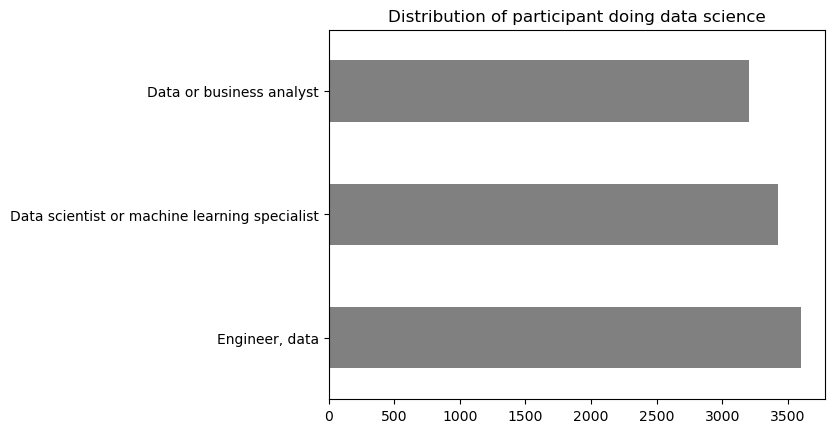

In [431]:
#distribution of devtype in DS
df2022_DS.devtype.value_counts().plot(kind='barh',color='grey',title='Distribution of participants doing data science')

Among these >10000 DS participants, about 1/3 were either one of the three devtypes, but there is the most of data engineers.

## Question 1: What cloud platforms people want to learn?
To answer this question, we will compare the platforms participants currently work on and the ones they wish to learn how to use.


In [436]:
df2022_DS['PlatformHaveWorkedWith'].head()

2                                     NaN
4                                     NaN
33                       AWS;Google Cloud
69                 Microsoft Azure;VMware
71    AWS;Managed Hosting;Microsoft Azure
Name: PlatformHaveWorkedWith, dtype: object

In the survey participant could select more than one platform they use, so to get counts for each platform, we have to separate these values for each cell. This can be done using the function explode()

In [66]:
#explode() by current platform
df2022_DS_explode_currentplatform = df2022_DS.assign(platform=df2022.PlatformHaveWorkedWith.str.split(';')).explode('platform').reset_index(drop=True)


In [70]:
df2022_DS_explode_currentplatform['platform'].unique() 

array([nan, 'Firebase', 'Microsoft Azure', 'DigitalOcean', 'Google Cloud',
       'VMware', 'Heroku', 'AWS', 'Linode', 'OVH', 'Managed Hosting',
       'Colocation', 'IBM Cloud or Watson', 'OpenStack',
       'Oracle Cloud Infrastructure'], dtype=object)

Now we see that the platforms are separated. Explode() separated each value and created a new row with the same info. Let's check how many more rows we have now.


In [437]:
df2022_DS.shape, df2022_DS_explode_currentplatform.shape

((10225, 83), (12917, 81))

There are about 2700 more rows after separating the platform values.

Now let's see what platform are used the most and by what type of DS participant.

[Text(0.5, 0, 'Count'), Text(0, 0.5, 'Platform')]

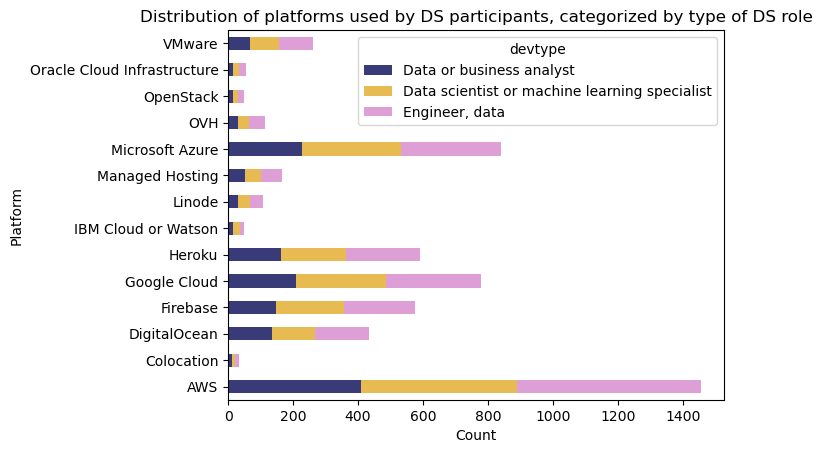

In [451]:
ax1 = df2022_DS_explode_currentplatform.groupby(['platform'])['devtype'].value_counts().unstack().plot(kind='barh', stacked=True,mark_right=True,colormap='tab20b',title='Distribution of platforms used by DS participants, categorized by type of DS role')
ax1.set(xlabel='Count', ylabel='Platform')

[Text(0.5, 0, 'Platform'), Text(0, 0.5, 'Count')]

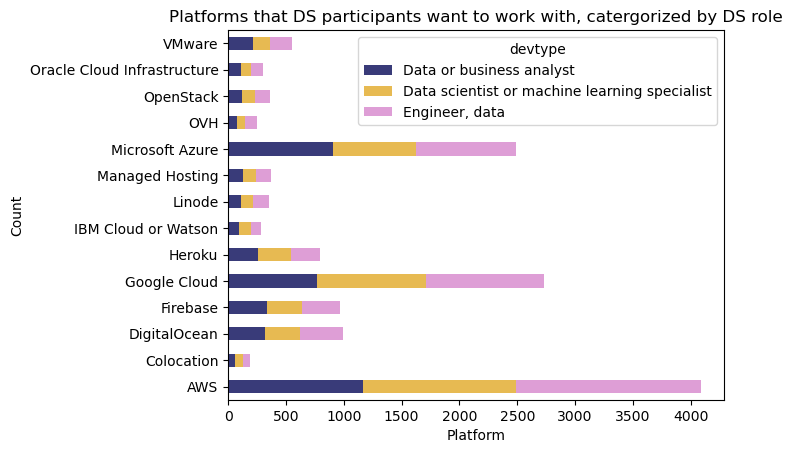

In [443]:
df2022_DS_explode_wantplat = df2022_DS.assign(platform=df2022_DS.PlatformWantToWorkWith.str.split(';')).explode('platform').reset_index(drop=True)

ax2 = df2022_DS_explode_wantplat.groupby(['platform'])['devtype'].value_counts().unstack().plot(kind='barh', stacked=True,colormap='tab20b',title="Platforms that DS participants want to work with, catergorized by DS role")
ax2.set(xlabel='Count', ylabel='Platform')

Since the two previous plot do not show me clearly what platforms DS people want to work on relatively to what they are working on now, I decided to calculate a ratio, where I divide the proportion of people wanting to learn a given platform by the proportion of people who are currently working on that platform. I substrated 1 to make my graph and separate out that platforms more people are wanting to work on.

demand = proportion platform want to work on - proportion platform using

In [462]:
demand = df2022_DS_explode_wantplat.groupby(['platform'])['devtype'].value_counts(normalize=True)-df2022_DS_explode_currentplatform.groupby(['platform'])['devtype'].value_counts(normalize=True)



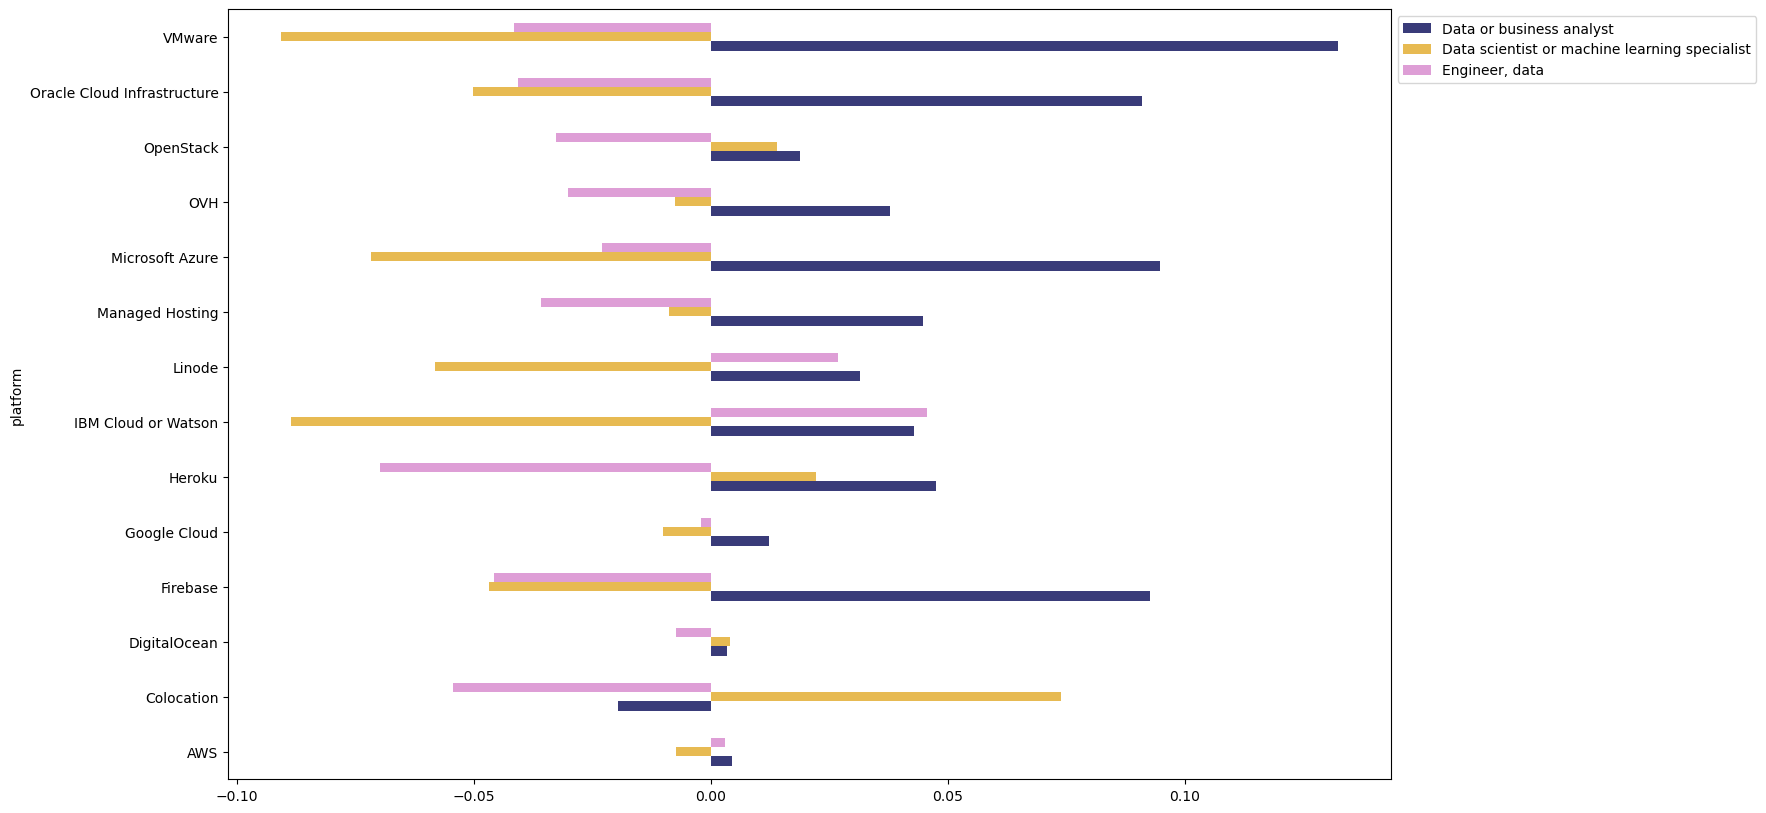

In [463]:
ax3 = demand.unstack().plot(kind='barh',colormap='tab20b',figsize=(15, 10)).legend(bbox_to_anchor=(1.0, 1.0))


In general, there more demand to learn new platforms from data analysts. Data engineers are interested in learning Linode, and IBM Cloud or Watson, and Data Scientists are interested in learning OpenStack, Heroku and Colocation.

### Conclusion question 1: Even if overall, the large majority of DS participants are using AWS and want to learn AWS, depending on the DS role, there is demand to learn new platforms that are less used and this demand varies depending on the DS role.

## Question 2: what programming languages do data science people work with and what should I focus on if I pick a DS role?


Let's take a look at the features I want to examine.

In [113]:
df2022_DS['devtype'].unique()

array(['Data scientist or machine learning specialist', 'Engineer, data',
       'Data or business analyst'], dtype=object)

In [346]:
df2022_DS.LanguageHaveWorkedWith.nunique()

4399

In [347]:
df2022_DS.LanguageWantToWorkWith.nunique()

4173

These features have the same challenge as platform features, so I have to use explode() to separate the values and get counts for each language. The plan: separate devtype into new rows, then subset by devtypes, then explode each language column to make counts per dev type.

Now from this subset of 532 data scientists, let look at the languages they are using and the ones they want to learn about.

<AxesSubplot:ylabel='language'>

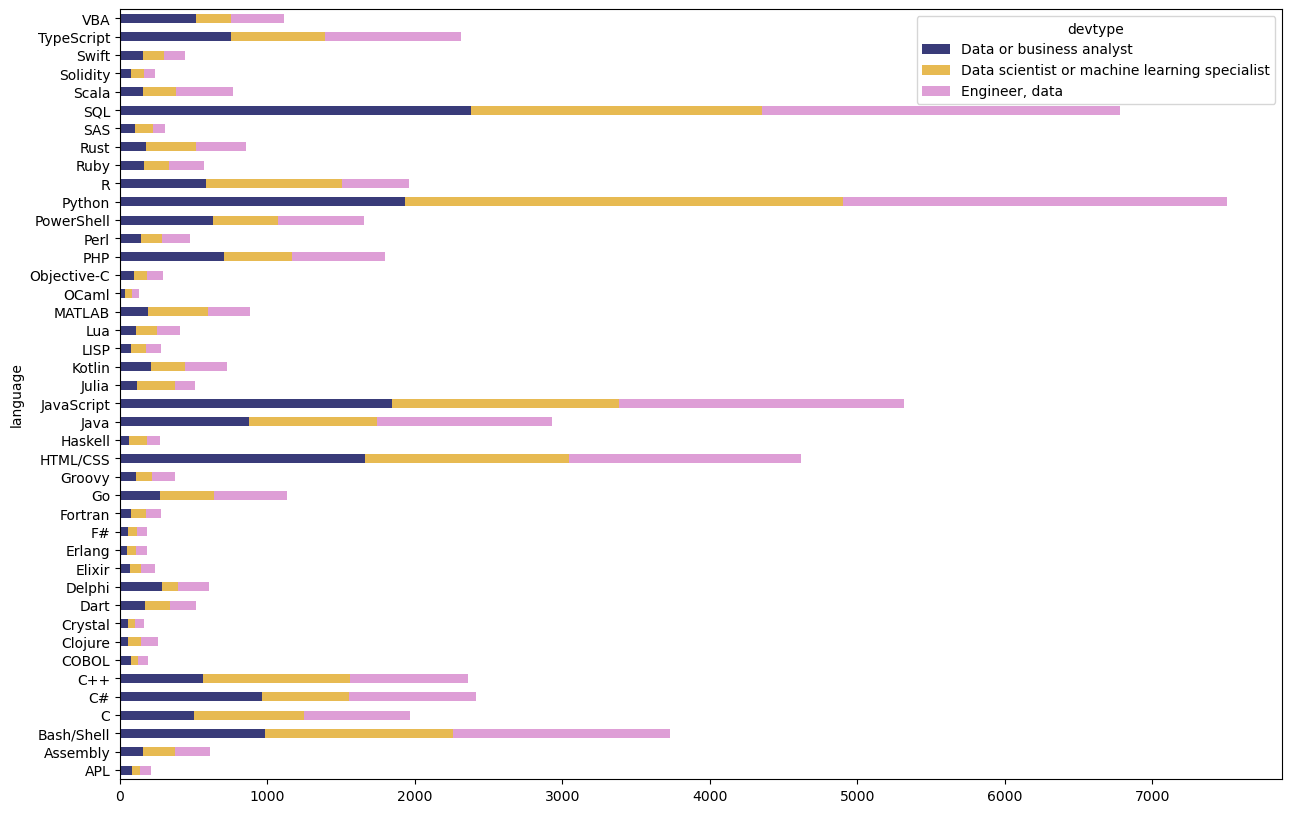

In [175]:
df2022_DS_explode_currentlanguage = df2022_DS.assign(language=df2022_DS.LanguageHaveWorkedWith.str.split(';')).explode('language').reset_index(drop=True)
df2022_DS_explode_currentlanguage.groupby(['language'])['devtype'].value_counts().unstack().plot(kind='barh', stacked=True,colormap='tab20b',figsize=(15,10))

Let's keep in mind that the participants here select a DS role as their devtype but they can also be other devtype, this is something we can look closer to explain the distribution of other languages than Python, R or SQL.

In [ ]:
Next I wanted to know, if I decide to go for one of the DS roles, what type of languages should I focus on?

In [202]:
# among the languages that are usually used by data science people, who uses most of which language?
DS_lang=['SQL','Python','R','Bash/Shell']
df2022_DSlang = df2022_DS_explode_currentlanguage[df2022_DS_explode_currentlanguage['language'].isin(DS_lang)]
df2022_DSlang['language'].unique()

(array(['Python', 'SQL', 'Bash/Shell', 'R'], dtype=object), (19979, 81))

<AxesSubplot:ylabel='devtype'>

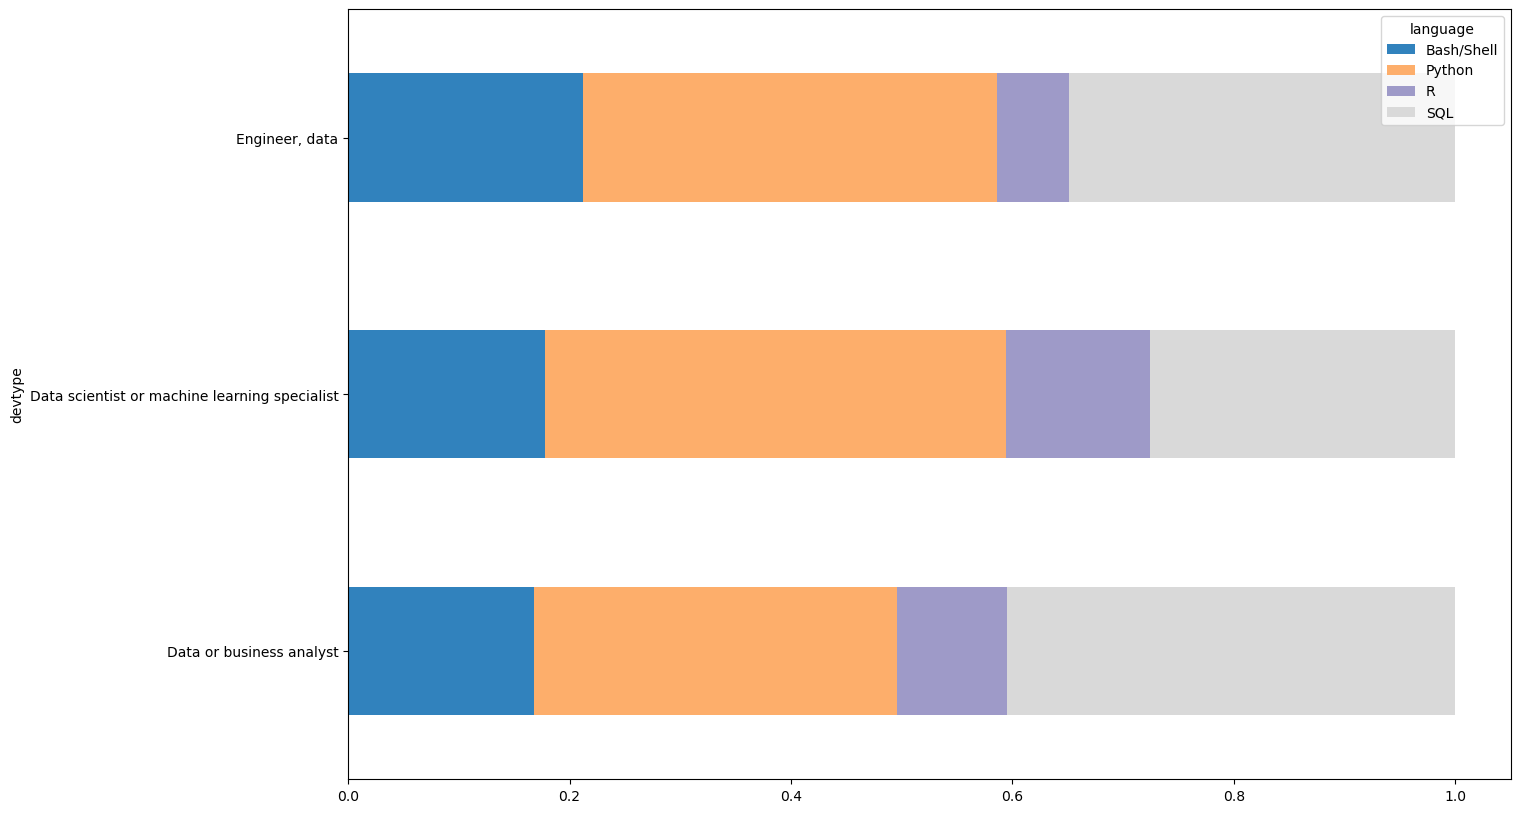

In [348]:
df2022_DSlang.groupby(['devtype'])['language'].value_counts(normalize=True).unstack().plot(kind='barh', stacked=True,colormap='tab20c',figsize=(15,10))

A data engineer with use more Bach/Shell and Python and SQL, while a Data Scientist uses more Python and R, and finally a data analyst uses a lot of SQL.

Now let's look at what language DS participants want to learn more of.

<AxesSubplot:ylabel='language'>

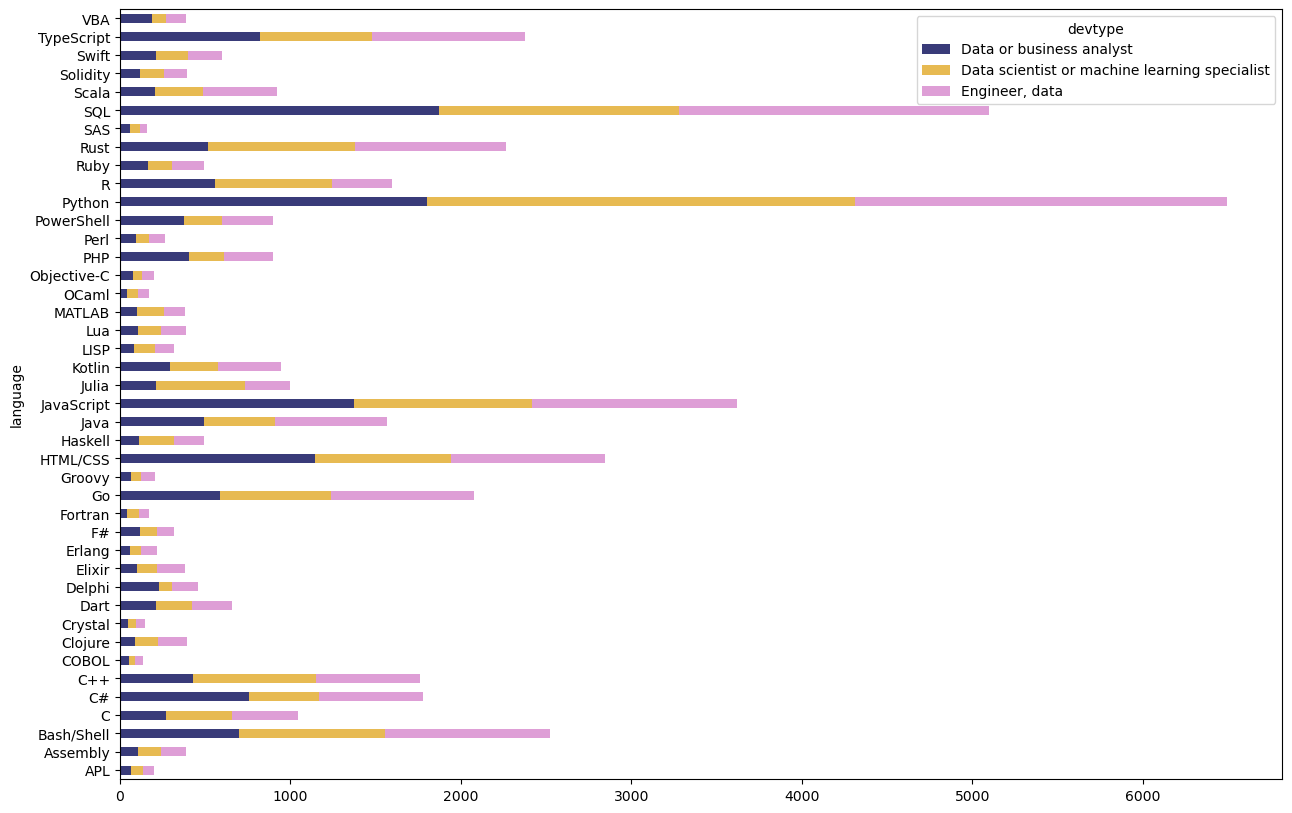

In [465]:
df2022_DS_explode_wantlanguage = df2022_DS.assign(language=df2022_DS.LanguageWantToWorkWith.str.split(';')).explode('language').reset_index(drop=True)
df2022_DS_explode_wantlanguage.groupby(['language'])['devtype'].value_counts().unstack().plot(kind='barh', stacked=True,colormap='tab20b',figsize=(15,10))




In [471]:
difL = df2022_DS_explode_wantlanguage.groupby(['language'])['devtype'].value_counts(normalize=True)-df2022_DS_explode_currentlanguage.groupby(['language'])['devtype'].value_counts(normalize=True)



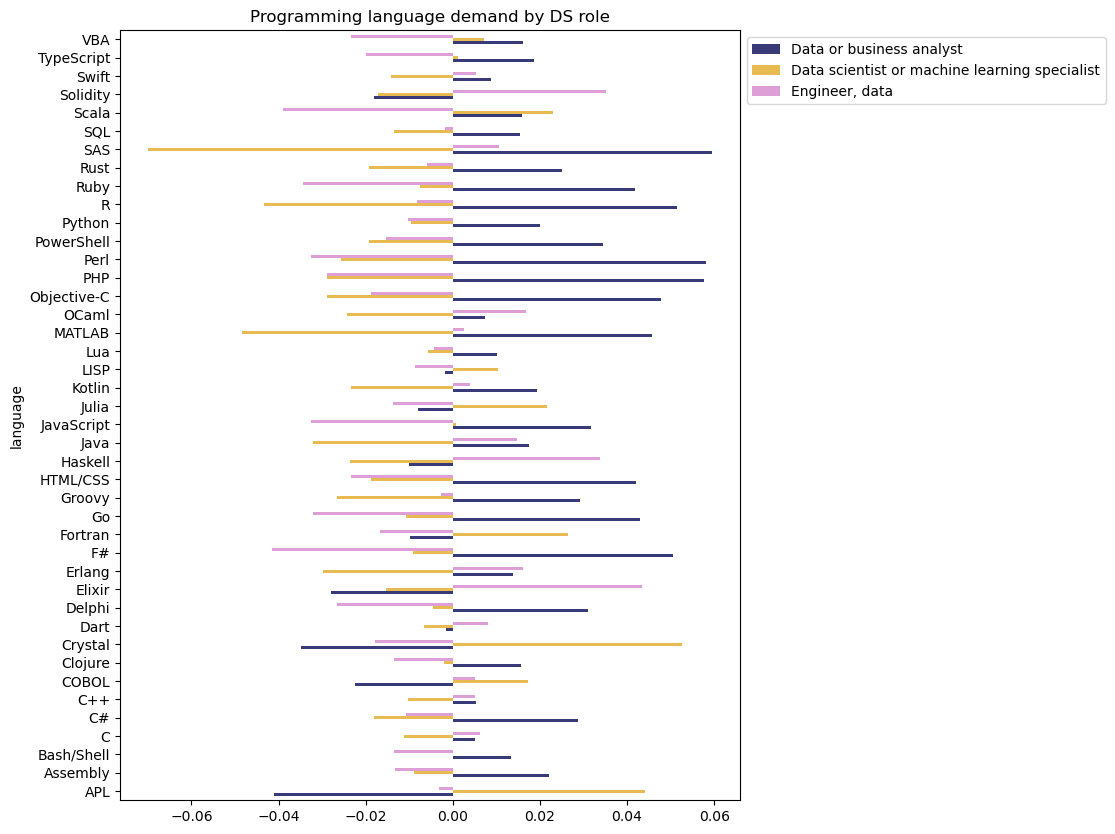

In [476]:
difL.unstack().plot(kind='barh',colormap='tab20b',figsize=(8, 10),title='Programming language demand by DS role').legend(bbox_to_anchor=(1.0, 1.0))

In [ ]:
Here we see again that data analysts selected the most new languages they want to learn as opposed to Data Scientist and Data Engineers.


In [488]:
#separate ech learning platform
df2022_DS_explode_certif = df2022_DS.assign(certif=df2022_DS.LearnCodeCoursesCert.str.split(';')).explode('certif').reset_index(drop=True)


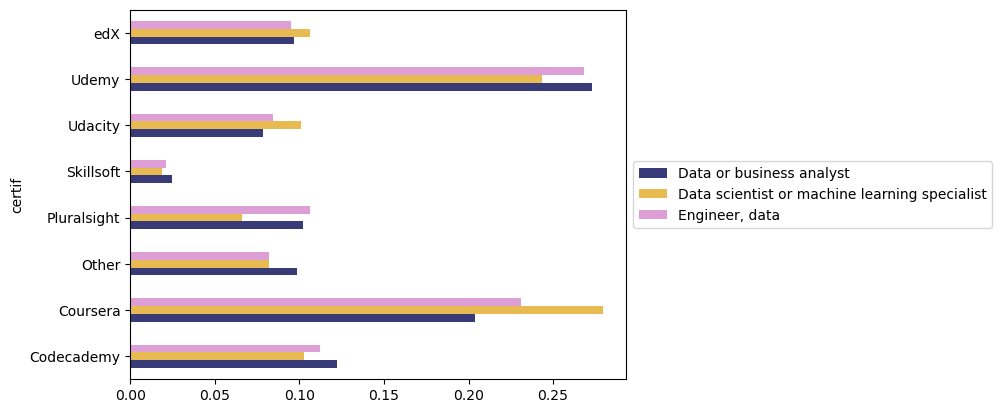

In [489]:
df2022_DS_explode_certif.groupby('devtype').certif.value_counts(normalize=True).unstack(0).plot(kind='barh', colormap='tab20b')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Question 4: How well are Data Science roles paid in the US?



In [490]:
#changing format of YearsCodePro to continuous
df2022_DS['YearsCodePro'].unique()


array(['5', '10', '18', '15', '3', nan, '7', '22', '28', '4', '8', '14',
       '12', '11', '19', '20', '37', '2', '1', '40', '6',
       'Less than 1 year', '25', '9', '26', '13', '38', '17', '31', '29',
       '35', '16', '32', '24', '30', '43', '33', '21', '23', '27', '41',
       '34', 'More than 50 years', '45', '36', '50', '42', '46', '39',
       '44', '48', '47'], dtype=object)

In [491]:
#Change YearsCode and YearsCodePro to continuous variable.
# replace strings of 'Less than 1 year' and 'More than 50 years' to 0 and 51
df2022_DS['YearsCodeProNum'] = df2022_DS['YearsCodePro']
df2022_DS.loc[df2022_DS['YearsCodeProNum'] == 'Less than 1 year', 'YearsCodeProNum'] = 0
df2022_DS.loc[df2022_DS['YearsCodeProNum'] == 'More than 50 years','YearsCodeProNum'] = 51
df2022_DS['YearsCodeProNum'] = df2022_DS['YearsCodeProNum'].dropna().astype('float') #changing format


/var/folders/dd/nb8m5vwd1sz3_s49jh1plcfr0000gn/T/ipykernel_3009/1418905998.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2022_DS['YearsCodeProNum'] = df2022_DS['YearsCodePro']
/var/folders/dd/nb8m5vwd1sz3_s49jh1plcfr0000gn/T/ipykernel_3009/1418905998.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2022_DS['YearsCodeProNum'] = df2022_DS['YearsCodeProNum'].dropna().astype('float') #changing format


In [494]:
#subsetting the survey by participants living in the US 
df2022_DS_USA=df2022_DS[df2022_DS['Country']=='United States of America']

Here is a boxplot showing the distribution of Yearly compensation


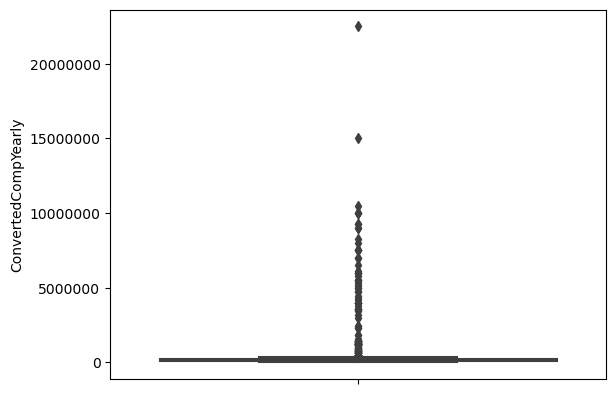

In [525]:
sns.boxplot(y='ConvertedCompYearly',
            data=df2022_DS_USA)
plt.ticklabel_format(style='plain', axis='y')

So I am going to remove the two outliers...

In [530]:
df2022_DS_USA[df2022_DS_USA['ConvertedCompYearly']<=1.5e6].groupby('devtype').ConvertedCompYearly.describe().astype(str)

,count,mean,std,min,25%,50%,75%,max
devtype,,,,,,,,
Data or business analyst,479.0,161799.0083507307,168079.27796701188,36.0,90000.0,120000.0,170000.0,1440000.0
Data scientist or machine learning specialist,450.0,189949.06666666668,190424.30467419405,180.0,102250.0,145000.0,203750.0,1440000.0
"Engineer, data",610.0,198883.33114754097,206703.0829618803,36.0,110000.0,150000.0,200000.0,1500000.0


In [ ]:
There is a big difference between the mean and median yearly compensations, so I will make boxplots to visualize the potnetial outliers.

(array([0, 1, 2]),
 [Text(0, 0, 'Engineer, data'),
  Text(1, 0, 'Data or business analyst'),
  Text(2, 0, 'Data scientist or machine learning specialist')])

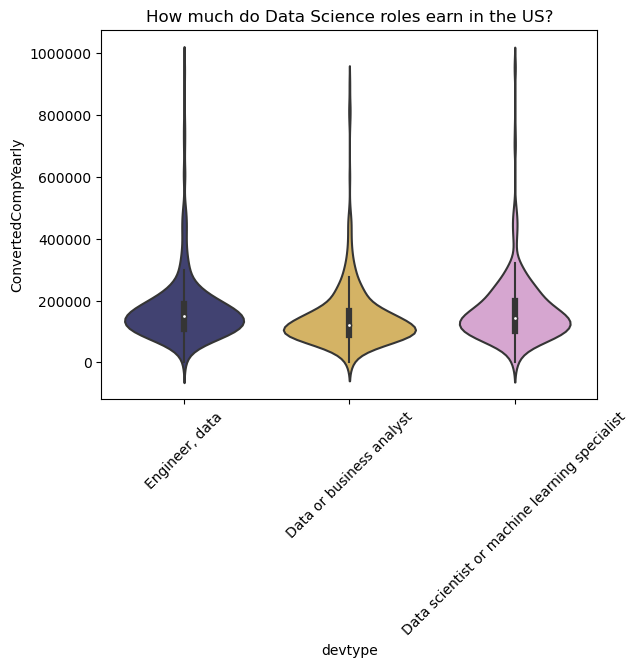

In [534]:
#setting up my devtype palette for seaborn plots

palette_tab20b = sns.color_palette("tab20b", 20)
palette = sns.color_palette([palette_tab20b[0],palette_tab20b[10],palette_tab20b[19]])
palette

sns.violinplot(x='devtype',y='ConvertedCompYearly',
            data=df2022_DS_USA[df2022_DS_USA['ConvertedCompYearly']<=1e6],
            palette=palette).set(title="How much do Data Science roles earn in the US?")
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)



Conclusion: salary mean is biased by very high outliers, better look at the median salary.

In [ ]:
Are DS roles paid differently 

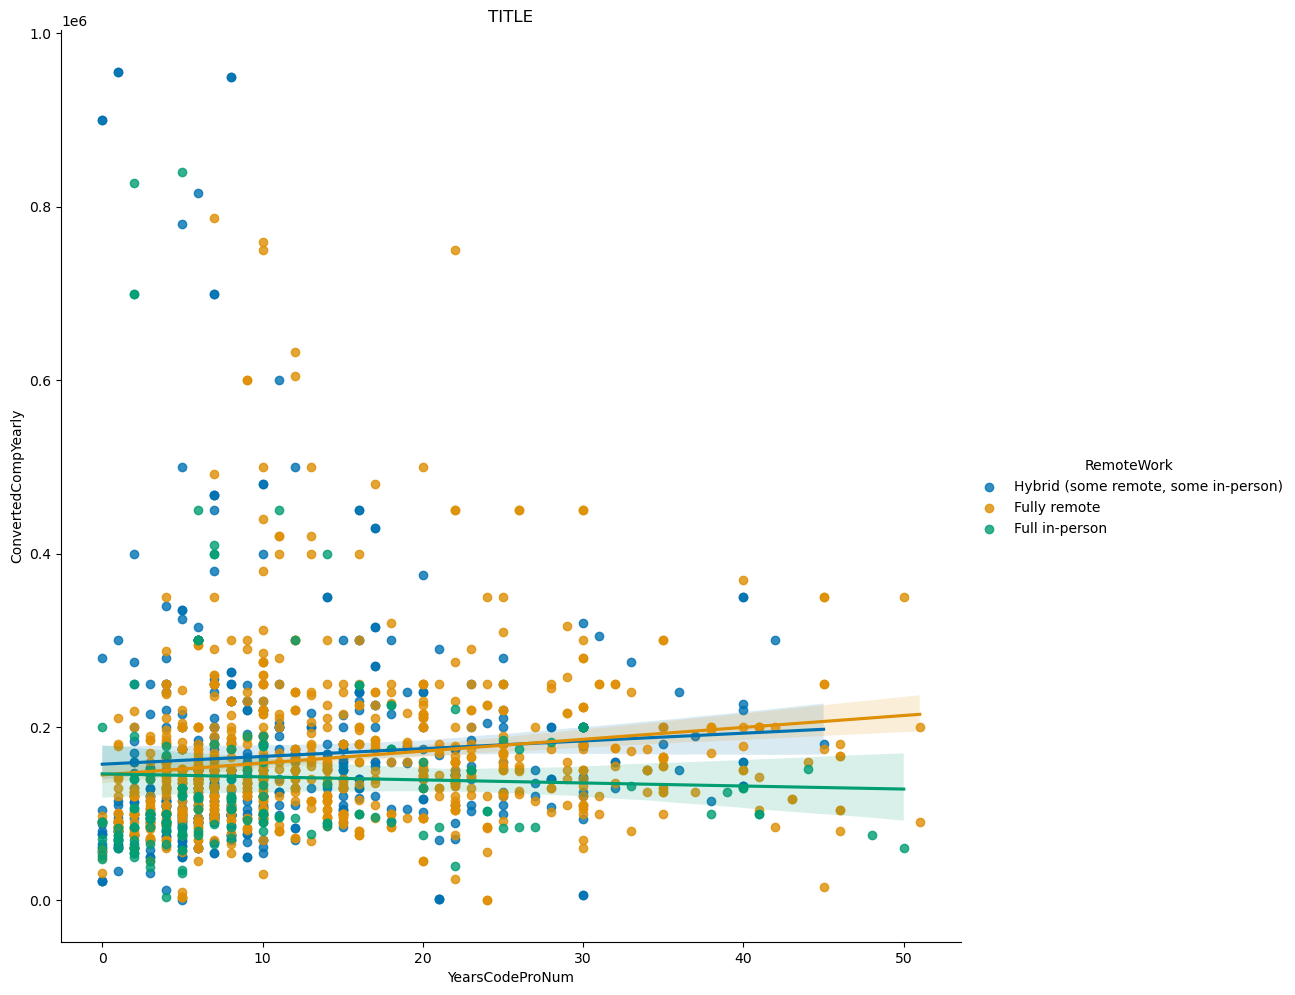

In [517]:
sns.lmplot(x='YearsCodeProNum',y='ConvertedCompYearly',
            data=df2022_DS_USA[df2022_DS_USA['ConvertedCompYearly']<=0.1e7],hue='RemoteWork',
           palette='colorblind', height=10).set(title='TITLE')

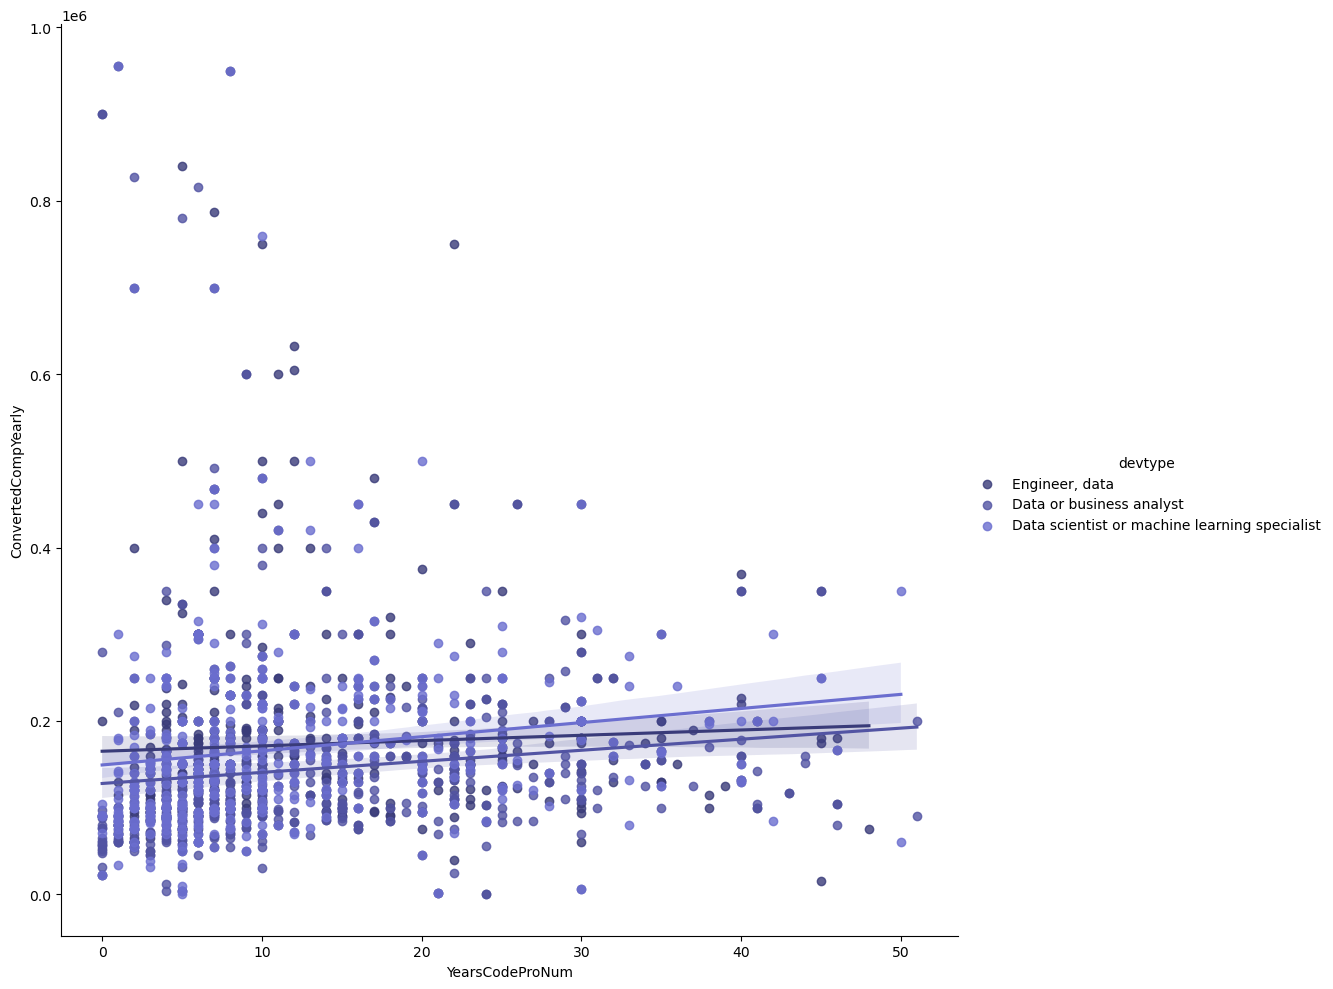

In [393]:
sns.lmplot(x='YearsCodeProNum',y='ConvertedCompYearly',
            data=df2022_DS_USA[df2022_DS_USA['ConvertedCompYearly']<=0.1e7],
           hue='devtype',palette='tab20b', height=10)

In [ ]:
Does 

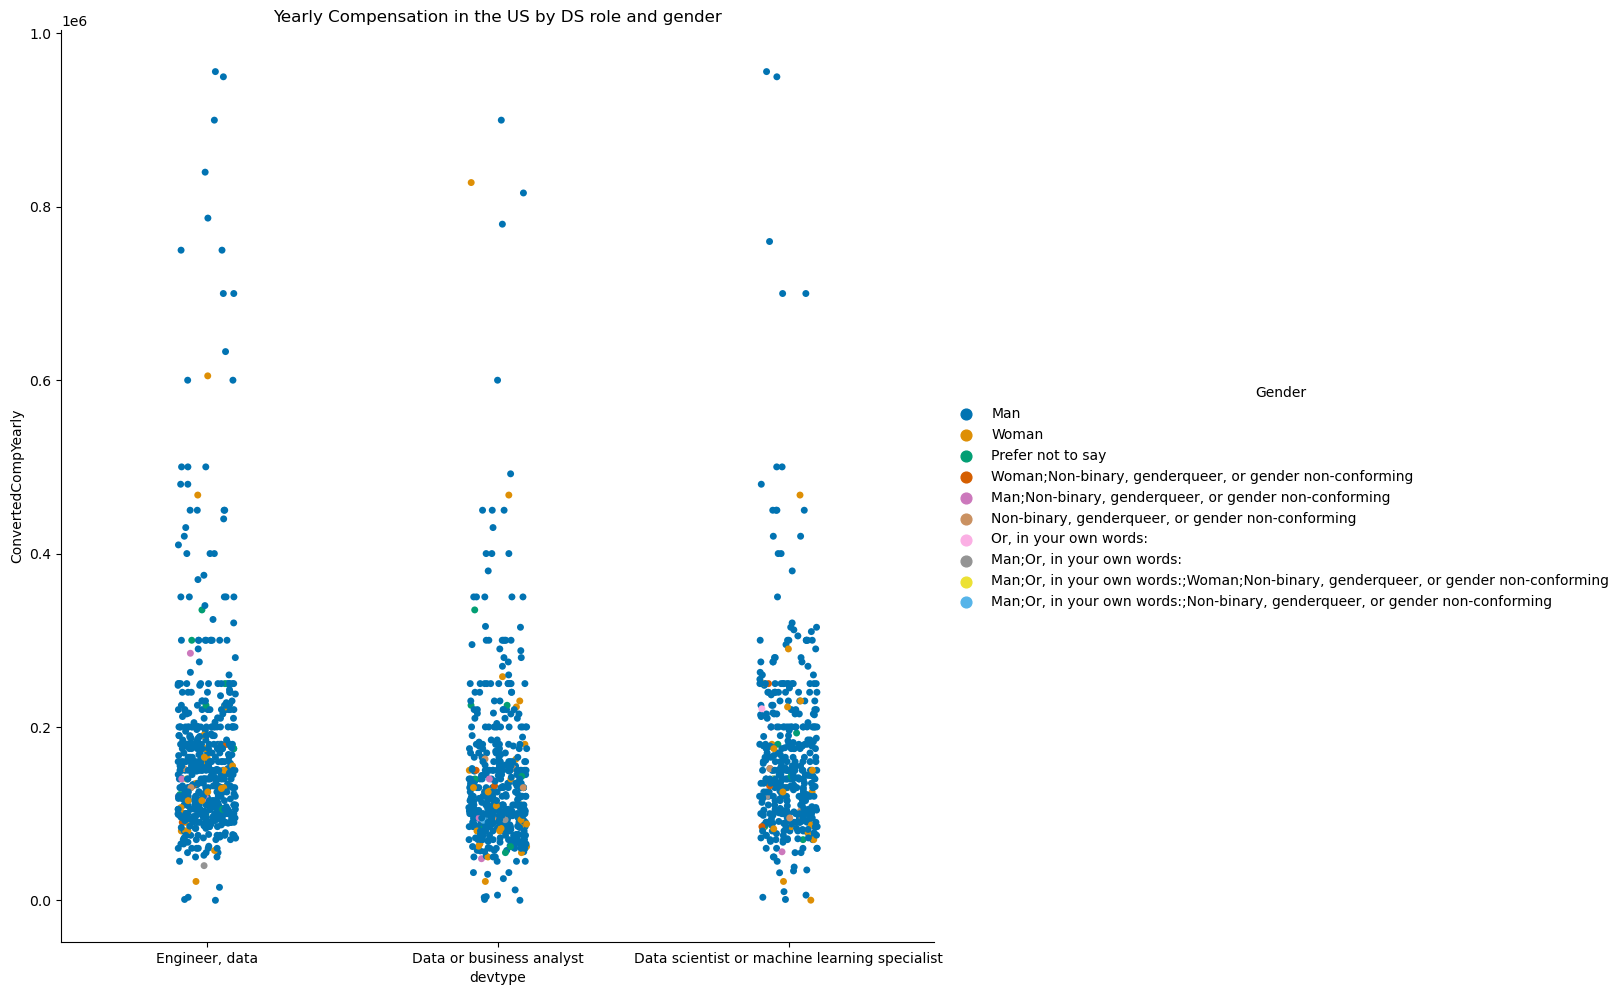

In [514]:
sns.catplot(hue='Gender',y='ConvertedCompYearly',
            data=df2022_DS_USA[df2022_DS_USA['ConvertedCompYearly']<=0.1e7],x='devtype',
            palette='colorblind',height=10).set(title='Yearly Compensation in the US by DS role and gender')

The main conclusion we can make here is that the overwhelmingly majority of data science professionals are men.

In [516]:
df2022_DS_USA_junior=df2022_DS_USA[df2022_DS_USA['YearsCodeProNum']<=2]
df2022_DS_USA_junior.groupby(by='devtype')['ConvertedCompYearly'].describe().astype(str)

,count,mean,std,min,25%,50%,75%,max
devtype,,,,,,,,
Data or business analyst,49.0,577367.7142857143,1470188.5822974094,21768.0,61200.0,76000.0,100000.0,7500000.0
Data scientist or machine learning specialist,55.0,345726.2363636364,1033699.5605485103,21768.0,85000.0,107000.0,165000.0,7500000.0
"Engineer, data",57.0,752941.5438596491,1583770.0875546937,21768.0,80000.0,101000.0,250000.0,7500000.0


<AxesSubplot:xlabel='devtype', ylabel='ConvertedCompYearly'>

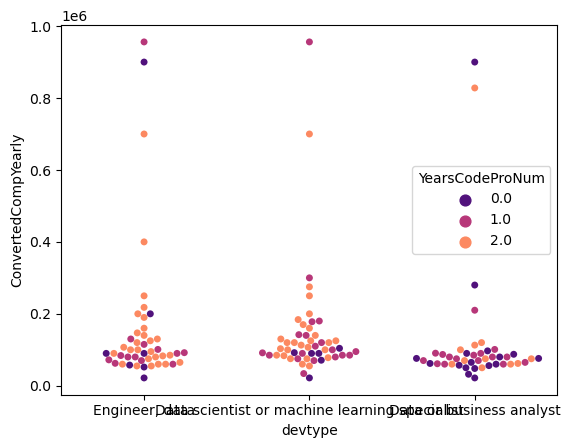

In [415]:
sns.swarmplot(x='devtype',y='ConvertedCompYearly',hue='YearsCodeProNum',
            data=df2022_DS_USA_junior[df2022_DS_USA_junior['ConvertedCompYearly']<=0.1e7],
            palette='magma')

The median mean of junior Data Science roles go from 76,000 USD for data analysts to  100,000 - 107,000 USD for data scientists and engineers.

Resources used for this project:
- https://medium.com/towards-data-science/crisp-dm-methodology-for-your-first-data-science-project-769f35e0346c 
- https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining